In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tweets = pd.read_csv("stock_tweets.csv")
stocks = pd.read_csv("stock_yfinance_data.csv")

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Modeling

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM, Dropout
from scikeras.wrappers import KerasRegressor
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.metrics import mean_squared_error, make_scorer
from tensorflow.keras import Input

In [5]:
stocks = pd.read_csv('stock_output.csv')

In [6]:
df = stocks[stocks['Stock Name'] == 'MSFT']

df.index = pd.to_datetime(df['Date']) 
  
# drop The original date column 
df = df.drop(['Date'], axis='columns') 

## LSTM

In [8]:
# Select the columns for prediction
features = ['Average_sentiment', 'Open', 'High', 'Low','Volume', 'Close']
data = df[features].values

# Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

#### Partitioning

In [9]:
# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create training data structure with 5 timesteps and 1 output
def create_dataset(data, time_step=5):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :-1])  # All features except 'Close'
        y.append(data[i, -1])  # 'Close' is the target variable
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 5)
X_test, y_test = create_dataset(test_data, 5)

# Reshape for LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

#### Model

In [10]:
from tensorflow.keras.layers import Layer, Dense, Permute, Multiply
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, Conv1D, BatchNormalization, TimeDistributed, Flatten, Input, LayerNormalization
from keras.regularizers import l2, l1_l2
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay


class AttentionLayer(Layer):
    def __init__(self, timesteps, **kwargs):
        self.timesteps = timesteps
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.dense = Dense(self.timesteps, activation='softmax')
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, input_dim)
        a = Permute((2, 1))(inputs)
        a = self.dense(a)
        a_probs = Permute((2, 1), name='attention_vec')(a)
        output_attention_mul = Multiply()([inputs, a_probs])
        return output_attention_mul

    def compute_output_shape(self, input_shape):
        return input_shape

#model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(100, return_sequences=True)),
    AttentionLayer(timesteps=X_train.shape[1]),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Training the RNN
model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.8328
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1675
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1093
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0846
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0879
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0803
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0793
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0846
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0800
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0817
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0762
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0804
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0838
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0854
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0557
Epoc

In [12]:
# Predicting the stock price
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(
    np.concatenate((np.zeros((predicted_stock_price.shape[0], scaled_data.shape[1] - 1)), predicted_stock_price), axis=1))[:, -1]

# Getting the real stock price for the test set
real_stock_price = scaler.inverse_transform(test_data[5:])[:, -1]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 732ms/step


In [13]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

# Print RMSE
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 10.015093111264061


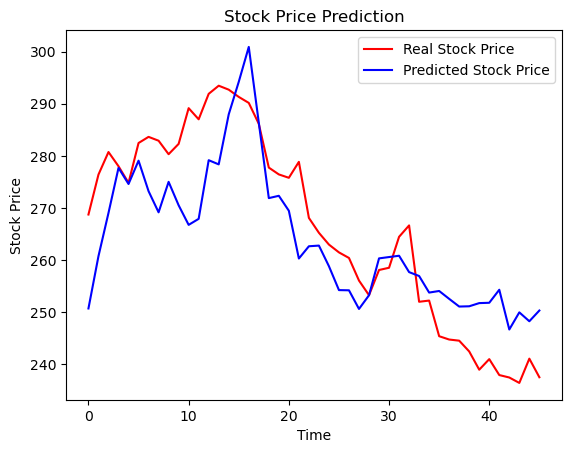

In [14]:
# Visualizing the results
plt.plot(real_stock_price, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

##### Forecasting

In [26]:
# Forecasting future stock prices
def forecast_future(model, data, time_step=5, future_steps=10):
    forecasted_data = []
    input_sequence = data[-time_step:]

    for _ in range(future_steps):
        prediction = model.predict(input_sequence[np.newaxis, :, :])
        forecasted_data.append(prediction[0, 0])
        
        new_input = np.zeros((time_step, data.shape[1]))
        new_input[:-1, :] = input_sequence[1:, :]
        new_input[-1, :-1] = input_sequence[-1, :-1]
        new_input[-1, -1] = prediction[0, 0]  
        input_sequence = new_input

    return forecasted_data

# Number of future steps to forecast
future_steps = 5

# Forecast future stock prices
forecasted_stock_price = forecast_future(model, test_data[:, :-1], time_step=5, future_steps=future_steps)

# Inverse transform the forecasted data
forecasted_stock_price = scaler.inverse_transform(
    np.concatenate((np.zeros((len(forecasted_stock_price), scaled_data.shape[1] - 1)), np.array(forecasted_stock_price).reshape(-1, 1)), axis=1))[:, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [31]:
# Fetch actual stock data for the next 5 business days
max_date = pd.to_datetime(df.index).max()
business_days = CustomBusinessDay()
end_date = max_date + 6 * business_days

# Ensure no timezone
stock_data = yf.Ticker("MSFT")
actual_data = stock_data.history(start=max_date, end=end_date)
actual_data.reset_index(inplace=True)
actual_data['Date'] = actual_data['Date'].dt.tz_localize(None)  # Ensure no timezone

In [32]:
# Extract actual future stock prices for comparison
actual_future_stock_price = actual_data['Close'].values[:future_steps]

# Calculate RMSE between forecasted and actual future stock prices
forecast_rmse = np.sqrt(mean_squared_error(actual_future_stock_price, forecasted_stock_price[:len(actual_future_stock_price)]))
print(f'Forecast vs Actual Future Stock Price RMSE: {forecast_rmse}')

Forecast vs Actual Future Stock Price RMSE: 15.13077947522377


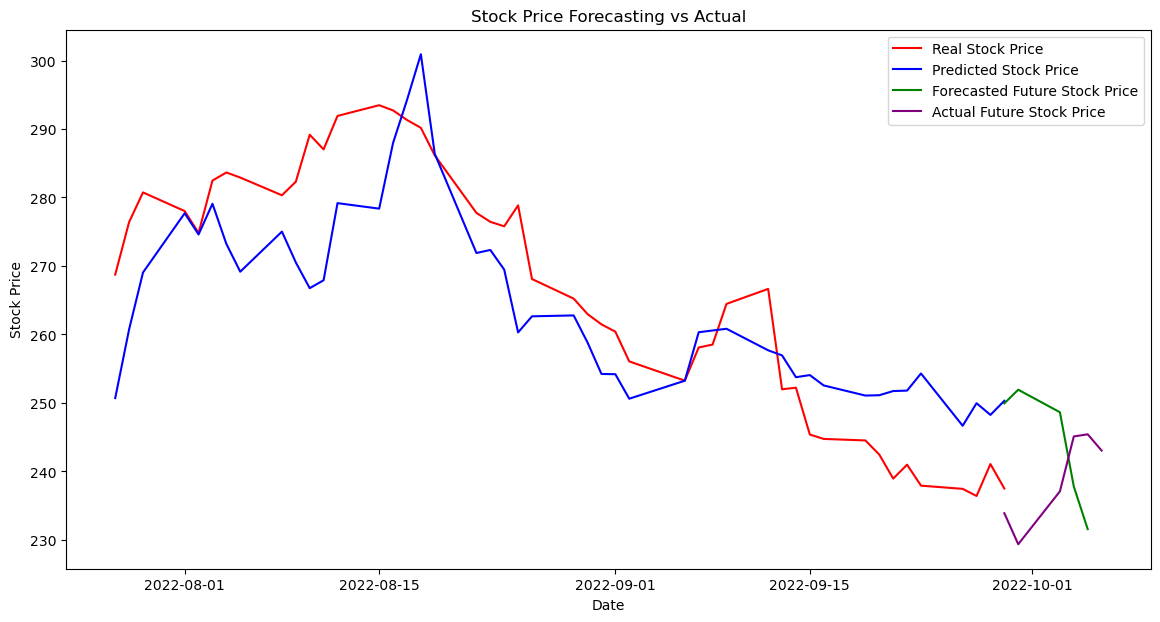

In [34]:
start_date = df.index[train_size + 5]

# Generate the date range for forecasting
forecast_dates = pd.date_range(start=start_date, periods=len(predicted_stock_price) + future_steps, freq='B')

# Plot actual vs. forecasted
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size+5:], real_stock_price, color='red', label='Real Stock Price')
plt.plot(df.index[train_size+5:], predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.plot(forecast_dates[-future_steps:], forecasted_stock_price, color='green', label='Forecasted Future Stock Price')
plt.plot(actual_data['Date'], actual_data['Close'].values, color='purple', label='Actual Future Stock Price')
plt.title('Stock Price Forecasting vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [18]:
# Calculate Cosine Similarity
dot_product = np.dot(actual_future_stock_price,forecasted_stock_price[:len(actual_future_stock_price)])
norm_a = np.linalg.norm(actual_future_stock_price)
norm_b = np.linalg.norm(forecasted_stock_price[:len(actual_future_stock_price)])
cosine_similarity = dot_product / (norm_a * norm_b)
cosine_similarity

0.9973086393405645

The other notebook is well-commented. This notebook is to get the MSFT results to be compared with.